# GR5293 - Proj1 - Group9
## Prediction and Classification on the shares of news
#### Machine learning pipeline with random forest
* Feature Engineering
* Train validation test split
* K-fold cross validation
* Rank the feature importance to interpret the result and give the orientation of further dimension reduction to enhance the depoliability of our model, state its business value
* Plot the ranked feature importance barplot(horizontal), the AUC curve with cv iteration
* Plot the cv scores in feature selection (/w number of components)

#### Setup

In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import matplotlib
from matplotlib import pyplot as plt
import time
import os
import re
import gc
gc.enable()
print(os.getcwd())
mydir = os.getcwd() + "/"
%xmode plain
%matplotlib inline

/Users/kangshuoli/Documents/VScode_workspace/GR5293/EODS-Project1-Group9/doc
Exception reporting mode: Plain


#### Read in data

In [4]:
fraud_df = pd.read_csv(
    '../data/fraud_cleaned_ver1.csv', 
    header = 0
)
fraud_df = fraud_df.iloc[:,1:]
fraud_df.shape

(151919, 156)

In [5]:
fraud_df

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,TARGET
0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,67500.0,80865.0,5881.5,67500.0,0.031329,-13439.0,-2717.0,-311.0,-3227.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.0,225000.0,918468.0,28966.5,697500.0,0.016612,-14086.0,-3028.0,-643.0,-4911.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,0.0,189000.0,773680.5,32778.0,679500.0,0.010006,-14583.0,-203.0,-615.0,-2056.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151914,0.0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327.0,-236.0,-8456.0,-1982.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
151915,0.0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775.0,365243.0,-4388.0,-4090.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
151916,0.0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966.0,-7921.0,-6737.0,-5150.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
151917,0.0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961.0,-4786.0,-2562.0,-931.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


#### Split the features and label

In [6]:
feature_df = fraud_df.iloc[:,np.arange(fraud_df.shape[1] - 1)]
response_df = fraud_df.iloc[:,-1].astype(int)
feature_df.shape

(151919, 155)

In [7]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151919 entries, 0 to 151918
Columns: 155 entries, CNT_CHILDREN to EMERGENCYSTATE_MODE_Yes
dtypes: float64(155)
memory usage: 179.7 MB


#### Post-process the data
##### Make corrections on data type
* Extract columns with "FLAG", "TYPE" in their names as categorical data
* Some columns with all integers but have "CNT", "DAYS" in their names would not be converted
* Unique value <= 10 can be interpreted as categorical

In [8]:
for name in feature_df.columns:
    print(name)

CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
EXT_SOURCE_2
APARTMENTS_AVG
YEARS_BEGINEXPLUATATION_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
LIVINGAREA_AVG
APARTMENTS_MODE
YEARS_BEGINEXPLUATATION_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
LIVINGAREA_MODE
APARTMENTS_MEDI
YEARS_BEGINEXPLUATATION_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
LIVINGAREA_MEDI
TOTALAREA_MODE
OBS_30_CNT_SOCIAL_CIRCLE
DEF_30_CNT_SOCIAL_CIRCLE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
DAYS_LAST_PHONE_CHANGE
NAME_CONTRACT_TYPE_Revolving loans
CODE_GENDER_M
CODE_GENDER

In [9]:
for name in feature_df.columns:
    print(name, len(feature_df[name].unique()))

CNT_CHILDREN 13
AMT_INCOME_TOTAL 1616
AMT_CREDIT 4822
AMT_ANNUITY 12219
AMT_GOODS_PRICE 821
REGION_POPULATION_RELATIVE 79
DAYS_BIRTH 17266
DAYS_EMPLOYED 11166
DAYS_REGISTRATION 14984
DAYS_ID_PUBLISH 6072
FLAG_MOBIL 2
FLAG_EMP_PHONE 2
FLAG_WORK_PHONE 2
FLAG_CONT_MOBILE 2
FLAG_PHONE 2
FLAG_EMAIL 2
CNT_FAM_MEMBERS 16
REGION_RATING_CLIENT 3
REGION_RATING_CLIENT_W_CITY 3
HOUR_APPR_PROCESS_START 24
REG_REGION_NOT_LIVE_REGION 2
REG_REGION_NOT_WORK_REGION 2
LIVE_REGION_NOT_WORK_REGION 2
REG_CITY_NOT_LIVE_CITY 2
REG_CITY_NOT_WORK_CITY 2
LIVE_CITY_NOT_WORK_CITY 2
EXT_SOURCE_2 83094
APARTMENTS_AVG 5533
YEARS_BEGINEXPLUATATION_AVG 952
ELEVATORS_AVG 10115
ENTRANCES_AVG 2048
FLOORSMAX_AVG 920
LIVINGAREA_AVG 9106
APARTMENTS_MODE 3960
YEARS_BEGINEXPLUATATION_MODE 891
ELEVATORS_MODE 9852
ENTRANCES_MODE 1795
FLOORSMAX_MODE 547
LIVINGAREA_MODE 9207
APARTMENTS_MEDI 4348
YEARS_BEGINEXPLUATATION_MEDI 913
ELEVATORS_MEDI 9899
ENTRANCES_MEDI 1811
FLOORSMAX_MEDI 571
LIVINGAREA_MEDI 9183
TOTALAREA_MODE 5286
OBS_

In [10]:
categorical_col_list = []
for name in feature_df.columns:
    if len(feature_df[name].unique()) <= 10:
        categorical_col_list.append(name)
        feature_df[name] = feature_df[name].astype(int)

/var/folders/tz/1kfts8hs47xb2vd2_6cggx300000gn/T/ipykernel_33925/4143337950.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df[name] = feature_df[name].astype(int)


In [11]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151919 entries, 0 to 151918
Columns: 155 entries, CNT_CHILDREN to EMERGENCYSTATE_MODE_Yes
dtypes: float64(37), int64(118)
memory usage: 179.7 MB


#### Delete some special columns by screening
* Drop last column called EMERGENCYSTATE_MODE_Yes since it only has one level
* Drop predictors with AVG MODE MEDI, only keep medians

In [12]:
import re
pattern_avg_mode = re.compile('(.*_AVG$|.*_MODE$)')
dup_col_list = []
for name in feature_df.columns:
    if re.search(pattern_avg_mode, name):
        dup_col_list.append(name)

feature_df.drop(
    dup_col_list,
    inplace = True, 
    axis = 1
)

/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [13]:
dup_col_list

['APARTMENTS_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'LIVINGAREA_MODE',
 'TOTALAREA_MODE']

##### Stadardize
* Only standardize columns with non-categorical data

In [14]:
from sklearn.preprocessing import MinMaxScaler
# instantiate the scalar
minmax_scalar = MinMaxScaler(
    feature_range = (0, 1)
)
# split the feature_df into categorical and non-categorical subdf
feature_df_non_categorical = feature_df[[name for name in feature_df.columns if name not in categorical_col_list]]
feature_df_categorical = feature_df[[name for name in feature_df.columns if name in categorical_col_list]]

# only transform non_categorical df
feature_df_non_categorical_minmax = minmax_scalar.fit_transform(X = feature_df_non_categorical) # return np.ndarray
# convert it into a dataframe
feature_df_std_categorical_minmax = pd.DataFrame(
    data = feature_df_non_categorical_minmax, 
    columns = feature_df_non_categorical.columns
)
# concatenate categorical df and non-categorical df
feature_df_minmax = pd.concat([feature_df_std_categorical_minmax, feature_df_categorical], axis = 1)
# dtype conversion
for name in list(feature_df_minmax.columns):
    if name in categorical_col_list:
        feature_df_minmax[name] = feature_df_minmax[name].astype(int)

In [15]:
feature_df_minmax

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ORGANIZATION_TYPE_XNA,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,0.000000,0.001512,0.090287,0.088688,0.076404,0.256321,0.898410,0.045086,0.852140,0.676385,...,0,0,0,0,0,0,0,1,0,0
1,0.000000,0.002089,0.311736,0.131644,0.270787,0.045016,0.482252,0.043648,0.951929,0.955579,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,0.000358,0.008955,0.015186,0.005618,0.429796,0.671757,0.039658,0.987395,0.507403,...,0,0,0,0,0,0,0,0,0,0
3,0.052632,0.001704,0.218094,0.105350,0.162921,0.226010,0.634893,0.038846,0.973938,0.250343,...,0,0,0,0,0,0,1,0,0,0
4,0.000000,0.001396,0.181943,0.120237,0.158427,0.134537,0.606575,0.046219,0.975073,0.686155,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151914,0.000000,0.001127,0.052360,0.099849,0.044944,0.446855,0.906045,0.046133,0.657263,0.697451,...,0,0,0,0,0,0,0,1,0,0
151915,0.000000,0.000396,0.056067,0.039089,0.044944,0.344429,0.253775,1.000000,0.822147,0.375668,...,1,0,0,0,0,0,0,1,0,0
151916,0.000000,0.001089,0.157969,0.109305,0.134831,0.065247,0.584753,0.026076,0.726937,0.213860,...,0,0,0,0,0,0,1,0,0,0
151917,0.000000,0.001243,0.081175,0.071130,0.068539,0.069553,0.755968,0.034258,0.896158,0.857884,...,0,0,0,0,0,0,0,1,0,0


#### Modeling

In [16]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#### Train test split

In [17]:
def train_test_split_with_shuffle(feature_df_, response_df_ = response_df, test_size_ = 0.25):
    '''
    Implement train test split function and shuffle all the data
    Default using test_ratio = 0.25 and standardized dataframe
    Return global variables
    '''
    globals()['feature_train'], globals()['feature_test'], globals()['response_train'], globals()['response_test'] = train_test_split(
        feature_df_, 
        response_df_, 
        test_size = test_size_, 
        shuffle = True, 
        random_state = 42, 
        stratify = response_df_
    )
    globals()['response_train'] = pd.DataFrame(globals()['response_train'])
    globals()['response_test'] = pd.DataFrame(globals()['response_test'])
    list_p1 = ["feature", "response"]
    list_p2 = ["train", "test"]
    for p1 in list_p1:
        for p2 in list_p2:
            temp_var = p1 + '_' + p2
            print(f'The Size of {temp_var} is: {globals()[temp_var].shape}')

    # reshape the index
    # make them start from 0 and end at their shape[0] - 1
    for p1 in list_p1:
        for p2 in list_p2:
            temp_var = p1 + '_' + p2
            globals()[temp_var].index = np.arange(globals()[temp_var].shape[0], dtype = int)
    pass

train_test_split_with_shuffle(feature_df_ = feature_df_minmax, response_df_ = response_df)

The Size of feature_train is: (113939, 142)
The Size of feature_test is: (37980, 142)
The Size of response_train is: (113939, 1)
The Size of response_test is: (37980, 1)


#### Feature Engineering
* Feature selection by RFE / SelectFromModel / PCA / LASSO / LLE
* Extreme imbalanced data -> resampling
* Only 6% of data is fraudulent this would cause the classifier onlt predict no fraudulent and get the result of 90%+ accuracy

##### Visualize the labels

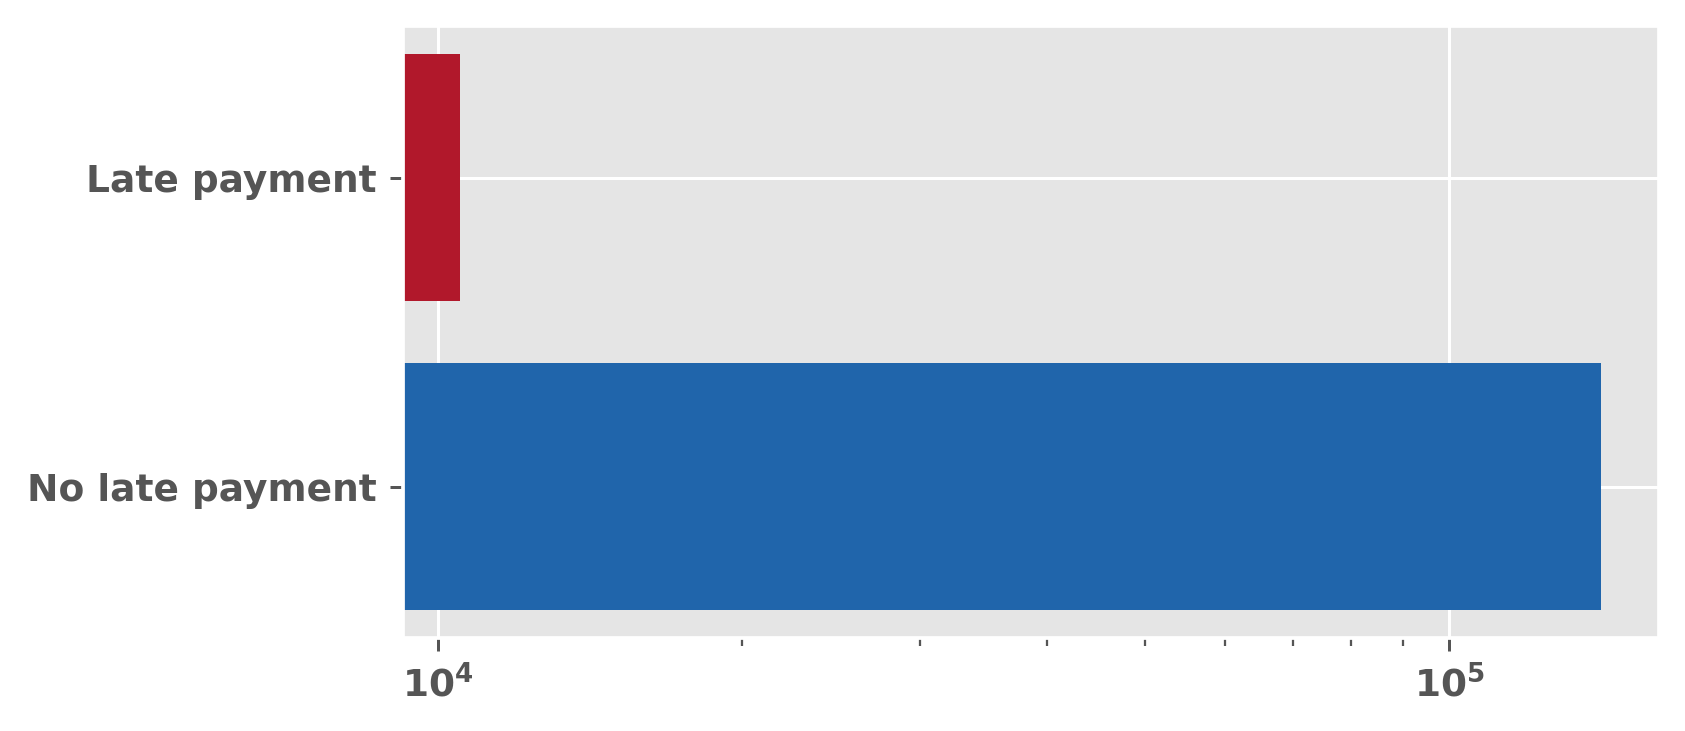

In [18]:
from matplotlib import cm
plt.style.use('ggplot')
plt.rcParams["font.weight"] = "bold"
my_colormap = cm.get_cmap(name = 'RdBu')
color_value = np.linspace(start = 0.9, stop = 0.1, num = 2)
fig, ax = plt.subplots(1, 1, figsize = (6,3), dpi = 270)
for i in np.arange(2):
    ax.barh(
        y = i, 
        width = response_df[response_df == i].shape[0], 
        label = i, 
        color = my_colormap(color_value[i])
    )
ax.set_yticks(np.arange(2), ["No late payment", "Late payment"])
ax.set_xscale('log')
# ax.set_xlabel("Count")
plt.show()

#### Resampling after train test split
* Random Under-Sampling / Random Over-Sampling / Random under-sampling with imblearn / Random over-sampling with imblearn / Under-sampling: Tomek links / Synthetic Minority Oversampling Technique (SMOTE) / NearMiss / 

Use undersampling here since the amount of data is large, 
>Tomek links can extract the data from majority class "0" that are close to opposite classes. 

In [37]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
# sampler = RandomUnderSampler(
#     sampling_strategy = "auto", 
#     random_state = 42
# )

sampler = RandomOverSampler(
    sampling_strategy = "auto", 
    random_state = 42
)

feature_res, response_res = sampler.fit_resample(X = feature_train, y = response_train)

In [38]:
feature_res

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ORGANIZATION_TYPE_XNA,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,0.105263,0.003435,0.294135,0.195110,0.269663,0.081932,0.794656,0.042020,0.542720,0.729812,...,0,0,0,0,0,0,0,1,0,0
1,0.000000,0.001127,0.155029,0.061322,0.107865,0.336758,0.280953,0.013592,0.556988,0.467562,...,0,0,0,0,0,0,1,0,0,0
2,0.000000,0.000550,0.056180,0.044942,0.056180,0.142153,0.606632,0.042301,0.656291,0.881240,...,0,0,0,0,0,0,0,1,0,0
3,0.000000,0.000550,0.118921,0.090674,0.101124,0.094492,0.320950,1.000000,0.632823,0.565257,...,1,0,0,0,0,0,0,0,1,0
4,0.052632,0.000550,0.124854,0.095754,0.101124,0.392880,0.845080,0.043583,0.819796,0.537017,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212095,0.000000,0.001127,0.164755,0.124648,0.146067,0.147830,0.789186,0.036573,0.935717,0.631201,...,0,0,0,0,0,0,1,0,0,0
212096,0.000000,0.001127,0.101124,0.078213,0.101124,0.446855,0.605891,0.036518,0.646644,0.354144,...,0,0,0,0,0,0,0,1,0,0
212097,0.052632,0.000781,0.070272,0.052148,0.046067,0.257000,0.681443,0.045608,0.763213,0.101206,...,0,0,0,0,0,0,1,0,0,0
212098,0.000000,0.000358,0.055056,0.043149,0.055056,0.361433,0.925930,0.044888,0.914681,0.756984,...,0,0,0,0,0,0,0,1,0,0


In [39]:
response_res = np.array(response_res).ravel()

##### Feature Selection

In [22]:
random_state_ = 42
# SelectFromModel
sfm_clf = SelectFromModel(
    estimator = RandomForestClassifier(
        # max_depth = 10, 
        # n_estimators = 600, 
        # class_weight = "balanced"
    ), 
    threshold = None, 
    importance_getter = "auto", 
    norm_order = 1
)
sfm_clf.fit(X = feature_res, y = response_res)
feature_selected_sfm_clf = [name for i, name in enumerate(feature_res.columns) if sfm_clf.get_support()[i] == True]
feature_df_sfm_clf = pd.DataFrame(data = sfm_clf.transform(feature_res), columns = feature_selected_sfm_clf )
print('Selector------------------------------------------------------------')
print(f'Feature Importance Threshold: {sfm_clf.threshold_:0.4f} \nSelected Features: \n{feature_df_sfm_clf.columns}\n Number of Selected Features: {len(feature_selected_sfm_clf)}')


# PCA (w/o std) Not working
variance_explained = 0.85
pca_clf = PCA(
    n_components = variance_explained, 
    svd_solver = "auto", 
    random_state = random_state_
)
pca_clf.fit(X = feature_res, y = response_res)
feature_df_pca_clf = pd.DataFrame(pca_clf.transform(feature_res), columns = np.arange(pca_clf.n_components_, dtype = int))
print('PCA-----------------------------------------------------------------')
print(f'Variance explained: {np.sum(pca_clf.explained_variance_ratio_):0.4f} \nNumber of Components: {pca_clf.n_components_}')

Selector------------------------------------------------------------
Feature Importance Threshold: 0.0070 
Selected Features: 
Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2',
       'APARTMENTS_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI',
       'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LIVINGAREA_MEDI',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'CODE_GENDER_M',
       'NAME_EDUCATION_TYPE_Higher education'],
      dtype='object')
 Number of Selected Features: 26
PCA-----------------------------------------------------------------
Variance explained: 0.8513 
Number of Components: 30


In [29]:
params_rf_clf = {
    'n_estimators': [200], 
    'max_depth': [None, 4, 6, 8, 10, 12, 15], 
    'min_samples_split': [2, 4, 10, 20, 50], 
    'max_features': ["sqrt"], 
    'max_leaf_nodes': [None], 
    # 'min_impurity_decrease': [0.0, 0.1, 0.2, 0.5], 
    'n_jobs': [-1], 
    'bootstrap': [True], 
    'oob_score': [True], 
    'random_state': [0], 
    'verbose': [0], 
    'max_samples': [None], 
    # 'class_weight': [{"balanced"}]
}


# gridsearch_clf = GridSearchCV(
#     estimator = RandomForestClassifier(), 
#     param_grid = params_rf_clf, 
#     scoring = "f1_micor",
#     cv = 10, 
#     verbose = 1, 
#     n_jobs = -1
# )

randomsearch_clf = RandomizedSearchCV(
    estimator = RandomForestClassifier(), 
    param_distributions = params_rf_clf, 
    n_iter = 30, 
    scoring = "roc_auc",
    cv = 10, 
    verbose = 2, 
    n_jobs = -1,
    return_train_score = True
)

randomsearch_clf.fit(X = feature_df_sfm_clf, y = np.array(response_res).ravel())
best_rf_clf = randomsearch_clf.best_estimator_
best_score_clf = randomsearch_clf.best_score_
best_params_clf = randomsearch_clf.best_params_
training_score = randomsearch_clf.cv_results_
print(f'The best params: \n{best_params_clf}\nBest Score: {best_score_clf:0.4f}')

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_split=2, n_estimators=200, n_jobs=-1, oob_score=True, random_state=0, verbose=0; total time=  37.5s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_split=2, n_estimators=200, n_jobs=-1, oob_score=True, random_state=0, verbose=0; total time=  37.6s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_split=2, n_estimators=200, n_jobs=-1, oob_score=True, random_state=0, verbose=0; total time=  37.7s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_split=2, n_estimators=200, n_jobs=-1, oob_score=True, random_state=0, verbose=0; total time=  37.6s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_sampl

In [24]:
# RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

##### Prediction

In [40]:
# # resample test data
# feature_test_res, response_test_res = sampler.fit_resample(X = feature_test, y = response_test)

# feature selection on test set
feature_test_sfm = pd.DataFrame(
    data = sfm_clf.transform(feature_test), 
    columns = feature_df_sfm_clf.columns
)

from sklearn.metrics import auc, roc_curve
response_pred_clf = best_rf_clf.predict(feature_test_sfm)
pred_accu = accuracy_score(y_true = response_test, y_pred = response_pred_clf)
# pred_f1 = f1_score(response_pred_clf, response_test, labels = ["Limited shares", "Some shares", "Many shares", "Numerous shares"], average = 'macro')
pred_f1 = f1_score(y_true = response_test, y_pred = response_pred_clf)
pred_proba = best_rf_clf.predict_proba(feature_test_sfm)[:,1]
pred_auc = roc_auc_score(y_true = response_test, y_score = pred_proba)
print(f'Model params: \n{best_params_clf}\nModel performance:\nAccuracy: {pred_accu:0.4f}\nF1 Score: {pred_f1:0.4f}\nAUC: {pred_auc:0.4f}')

Model params: 
{'verbose': 0, 'random_state': 0, 'oob_score': True, 'n_jobs': -1, 'n_estimators': 200, 'min_samples_split': 2, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
Model performance:
Accuracy: 0.9306
F1 Score: 0.0120
AUC: 0.6844


In [41]:
response_pred_alt = best_rf_clf.predict(feature_df_sfm_clf)
pred_accu_alt = accuracy_score(y_true = response_res, y_pred = response_pred_alt)
# pred_f1 = f1_score(response_pred_clf, response_test, labels = ["Limited shares", "Some shares", "Many shares", "Numerous shares"], average = 'macro')
pred_f1_alt = f1_score(y_true = response_res, y_pred = response_pred_alt)
pred_proba_alt = best_rf_clf.predict_proba(feature_df_sfm_clf)[:,1]
pred_auc_alt = roc_auc_score(y_true = response_res, y_score = pred_proba_alt)
print(f'Model params: \n{best_params_clf}\nModel performance:\nAccuracy: {pred_accu_alt:0.4f}\nF1 Score: {pred_f1_alt:0.4f}\nAUC: {pred_auc_alt:0.4f}')

Model params: 
{'verbose': 0, 'random_state': 0, 'oob_score': True, 'n_jobs': -1, 'n_estimators': 200, 'min_samples_split': 2, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
Model performance:
Accuracy: 1.0000
F1 Score: 1.0000
AUC: 1.0000


In [31]:
response_test.sum() / response_test.shape[0]

TARGET    0.069247
dtype: float64

In [36]:
response_res.sum() / response_res.shape[0]

0.5